## import libraries

In [1]:
#import gensim for topic modelling
import gensim # https://radimrehurek.com/gensim/models/ldamodel.html
from gensim import corpora
from gensim.models import CoherenceModel #to calculate coherence
import time #to have today's date and to measure the time it takes to run scripts
timestr = time.strftime("%Y%m%d")
import pandas as pd
from collections import Counter #to count appearance of items in list
import numpy as np #for arrays

In [2]:
import plotly.graph_objs as go #to plot graphs
import plotly.offline as py

In [5]:
import plotly # for interactive graphs
import plotly.plotly as py
import plotly.offline as offline
plotly.offline.init_notebook_mode()
import plotly.graph_objs as go
import matplotlib #for the other graphs
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity #for cosine topic similarity

In [4]:
#get the clean text from the other notebook
%run ./p_03_prepare_text_paper.ipynb
# doc_clean = get_doc_clean() ##all interviews together
# df_all_interviews = df with original text + counry + number of interview + class for each paragraph.
# list_wordcount_drop (it is [0, 1, 2, 5, 7, 10, 20, 50])
# dict_clean_doc_x contains only the clean docs with > x words
# dict_doc_list_paras_x contains the original text only for paragraphs that have clean text (words) > x


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## convert corpus into a matrix

A DT matrix describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms

### creating the term dictionary

In [6]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
def get_dictionary(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    return(dictionary)

### creating the document term matrix

In [9]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
#this is also called Bag of Words corpus
def get_doc_term_matrix(dictionary, doc_clean):
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return(doc_term_matrix)

In [12]:
#decide for x>=10
var_drop_10 = 10 #drop all documents with number of words <= this number
doc_clean_10 = dict_clean_doc_x['>'+str(var_drop_10)]  #from p_03_prepare text
dictionary_10 = get_dictionary(doc_clean_10)
doc_term_matrix_10 = get_doc_term_matrix(dictionary_10, doc_clean_10)

# Analysing the parameters for the LDA Model

create an object for LDA model and train it on Document-Term matrix

In [13]:
# Creating the object for LDA model using gensim library + # Running and Trainign LDA model on the document term matrix.
def get_ldamodel(var_alpha, var_no_topics, var_passes, doc_term_matrix, dictionary):
    ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=var_no_topics, alpha=var_alpha,
                id2word = dictionary, random_state=1, passes=var_passes ,minimum_probability=0) 
            #use random_state for reproducity
    return(ldamodel)

In [14]:
var_passes = 50 #for now we choose 50, later we try a range
#number of passes also changes which model (number of topics) has the highest coherence!

## run for several alphas & number of topics

In [14]:
#compare different number of topics and parameters
#alpha (document-topic distribution) default is alpha='symmetric': Uses a fixed symmetric prior of 1.0 / num_topics
#eta (topic-word distribution) default is ’symmetric’: Uses a fixed symmetric prior of 1.0 / num_topics
#passes default is 1
#coherence score: measures how similar these words are to each other. Want to maximize!
#coherence cv: content vectors of words
list_alpha = [0.01, 0.02, 0.05]
list_no_topics = [10, 20, 30, 40]

In [15]:
df_models_10_alpha_topicnum = pd.DataFrame() #dataframe showing each run, number of topics + alpha + coherence
dict_models_10_alpha_topicnum = {} #saves all the runs
var_runs = len(list_alpha)*len(list_no_topics)

n = 0
for x in list_alpha:
    for y in list_no_topics:
        startTime = time.time() # to measure the time it takes to run the model
        ldamodel_xy = get_ldamodel(x, y, var_passes, doc_term_matrix_10, dictionary_10) #run the model
        executionTime_min = round((time.time() - startTime)/60, 1)
        dict_models_10_alpha_topicnum[str(y)+'_'+str(x)] = ldamodel_xy  #add model to dictionary_10
        coherence_model_lda = CoherenceModel(
           model=ldamodel_xy, texts=doc_clean_10, dictionary=dictionary_10, coherence='c_v')
        coherence_lda_xy = coherence_model_lda.get_coherence() #get the coherence score
        df_models_10_alpha_topicnum = df_models_10_alpha_topicnum.append({'alpha':x, 'number_of_topics':y, \
                'passes':var_passes, 'coherence':coherence_lda_xy, 'runtime_min':executionTime_min, \
                'docs_>':str(var_drop_10)}, ignore_index=True) #add to dataframe
        n+=1
        p = str(n)+' / ' + str(var_runs)+' done'
        print(p, end="\r") #\r is Carriage return, starts at the beginning of the line

In [17]:
#export dataframe with overview
df_models_10_alpha_topicnum.to_csv('.\\results\LDA_set_parameters\parameters_lda\qa_overview_10_alpha_topicnum_'+timestr+'.csv',
    sep=';', decimal=',')

In [18]:
df_models_10_alpha_topicnum[df_models_10_alpha_topicnum['coherence'] == df_models_10_alpha_topicnum['coherence'].max()]

alpha  number_of_topics  passes  coherence  runtime_min docs_>
11   0.05              40.0    50.0   0.414959          4.0     10

## comparing number of passes

In [15]:
#set alpha and number of topics again, based on results above
var_alpha_2 =  0.01
var_topics_2 =  20
#try these number of passes
list_passes = [1,2,5,10,25,50,75,100]

In [16]:
df_models_10_passes = pd.DataFrame() #dataframe showing each run, number of topics + alpha + coherence
dict_models_10_passes = {} #saves all the runs
var_runs = len(list_passes)

n = 0
for x in list_passes:
    startTime = time.time() # to measure the time it takes to run the model
    ldamodel_x = get_ldamodel(var_alpha_2, var_topics_2, x, doc_term_matrix_10, dictionary_10) #run the model
    executionTime_min = round((time.time() - startTime)/60, 1)
    dict_models_10_passes['passes_'+str(x)] = ldamodel_x  #add model to dictionary_10
    coherence_model_lda = CoherenceModel(
       model=ldamodel_x, texts=doc_clean_10, dictionary=dictionary_10, coherence='c_v')
    coherence_lda_x = coherence_model_lda.get_coherence() #get the coherence score
    df_models_10_passes = df_models_10_passes.append({'alpha':var_alpha_2, 'number_of_topics':var_topics_2, \
            'passes':x, 'coherence':coherence_lda_x, 'runtime_min':executionTime_min, 'docs_>':str(var_drop_10)}, \
            ignore_index=True) #add to dataframe
    n+=1
    p = str(n)+' / ' + str(var_runs)+' done'
    print(p, end="\r") #\r is Carriage return, starts at the beginning of the line

In [17]:
for x in ['coherence', 'runtime_min']:
    df_models_10_passes[x+'_diff'] = df_models_10_passes[x].diff()

In [18]:
df_models_10_passes

alpha  number_of_topics  passes  coherence  runtime_min docs_>  \
0   0.01              20.0     1.0   0.268051          0.1     10   
1   0.01              20.0     2.0   0.324203          0.3     10   
2   0.01              20.0     5.0   0.386169          0.7     10   
3   0.01              20.0    10.0   0.404301          1.2     10   
4   0.01              20.0    25.0   0.408387          2.4     10   
5   0.01              20.0    50.0   0.411039          4.3     10   
6   0.01              20.0    75.0   0.412262          6.6     10   
7   0.01              20.0   100.0   0.414433          8.9     10   

   coherence_diff  runtime_min_diff  
0             NaN               NaN  
1        0.056152               0.2  
2        0.061965               0.4  
3        0.018133               0.5  
4        0.004086               1.2  
5        0.002652               1.9  
6        0.001223               2.3  
7        0.002171               2.3

In [19]:
#export dataframe with overview
df_models_10_passes.to_csv('.\\results\LDA_set_parameters\passes_lda\qa_overview_10_passes_'+timestr+'.csv',
    sep=';', decimal=',')

#### graph

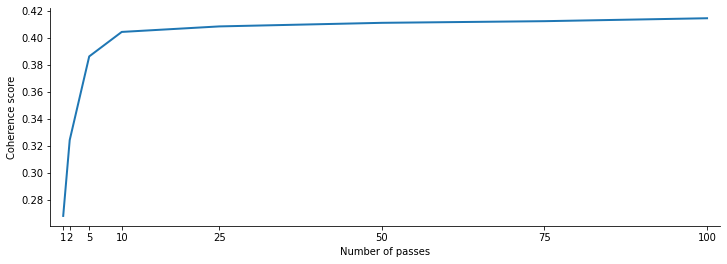

In [21]:
fig, ax1 = plt.subplots(figsize=(12,4))
list_passes = [int(item) for item in  df_models_10_passes['passes']]
list_coherence = df_models_10_passes['coherence']
ax1.plot(list_passes, list_coherence, linewidth=2.0)

for x in ['top', 'right']: #left
    ax1.spines[x].set_visible(False) 

#add labels on axis
ax1.set_xlabel('Number of passes', fontsize=10)
ax1.set_ylabel('Coherence score', fontsize=10)
    
#add x labels
ax1.set_xticks(list_passes)
ax1.set_xticklabels(list_passes, fontsize=10)

# remove gap between y and x axis
ax1.margins(x=0.02)

#save graph
for y in ['png', 'svg']: # 
    plt.savefig('.\\results\\LDA_set_parameters\\passes_lda\\qa_Coherence_for_passes_10_'+timestr+'_V01.'+y, \
            bbox_inches="tight") 

plt.show()

## compare topics for models with different number of topics

### run models

In [22]:
#choose alpha based on the results above
var_alpha_2 = var_alpha_2 #defined above!
#choose the range for the topic-numbers 
no_topics = [16, 18, 20, 22, 24, 26, 28] #around the topic number with best coherence score above!
var_passes = var_passes #defined on top of the notebook

In [23]:
df_models_10_topicnum = pd.DataFrame() #dataframe showing each run, number of topics + alpha + coherence
dict_models_10_topicnum = {} #saves all the runs
var_runs = len(no_topics)

n = 0

for y in no_topics:
    startTime = time.time()
    ldamodel_xy = get_ldamodel(var_alpha_2, y, var_passes, doc_term_matrix_10, dictionary_10) #run the model
    executionTime_min = round((time.time() - startTime)/60, 1)
    dict_models_10_topicnum['tnum_'+str(y)] = ldamodel_xy  #add model to dictionary
    coherence_model_lda = CoherenceModel(
       model=ldamodel_xy, texts=doc_clean_10, dictionary=dictionary_10, coherence='c_v')
    coherence_lda_xy = coherence_model_lda.get_coherence() #get the coherence score
    df_models_10_topicnum = df_models_10_topicnum.append({'alpha':var_alpha_2, 'number_of_topics':y, \
            'passes':var_passes, 'coherence':coherence_lda_xy, 'runtime_min':executionTime_min, 'docs_>':str(var_drop_10)}, \
            ignore_index=True) #add to dataframe
    n+=1
    p = str(n)+' / ' + str(var_runs)+' done'
    print(p, end="\r") #\r is Carriage return, starts at the beginning of the line

In [24]:
df_models_10_topicnum

alpha  number_of_topics  passes  coherence  runtime_min docs_>
0   0.01              16.0    50.0   0.405419          4.4     10
1   0.01              18.0    50.0   0.409420          4.2     10
2   0.01              20.0    50.0   0.411039          4.5     10
3   0.01              22.0    50.0   0.415965          4.7     10
4   0.01              24.0    50.0   0.411942          4.8     10
5   0.01              26.0    50.0   0.396373          4.9     10
6   0.01              28.0    50.0   0.392049          4.8     10

In [25]:
#export dataframe
df_models_10_topicnum.to_csv('.\\results\LDA_set_parameters\parameters_lda\qa_overview_10_topicnum_'+timestr+'.csv',
    sep=';', decimal=',')

### plot coherence

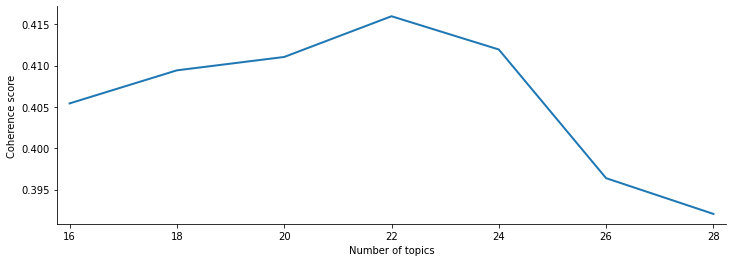

In [26]:
fig, ax1 = plt.subplots(figsize=(12,4))
list_topics = [int(item) for item in df_models_10_topicnum['number_of_topics']]
list_coherence = df_models_10_topicnum['coherence']
ax1.plot(list_topics, list_coherence, linewidth=2.0)

for x in ['top', 'right']: #left
    ax1.spines[x].set_visible(False) 

#add labels on axis
ax1.set_xlabel('Number of topics', fontsize=10)
ax1.set_ylabel('Coherence score', fontsize=10)
    
#add x labels
ax1.set_xticks(list_topics)
ax1.set_xticklabels(list_topics, fontsize=10)

# remove gap between y and x axis
ax1.margins(x=0.02)

#save graph
for y in ['png', 'svg']: # 
    plt.savefig('.\\results\\LDA_set_parameters\\parameters_lda\\qa_Coherence_for_topic_num_10_'+timestr+'_V01.'+y, \
            bbox_inches="tight") 

plt.show()

### Topic Similarity

#### graphs with cosine similarity comparing distribution of topics over documents

cosine similarity: cosine similarity is a measure of similarity between two sequences of numbers. For defining it, the sequences are viewed as vectors in an inner product space, and the cosine similarity is defined as the cosine of the angle between them. <br>
for positive only: 0 if orthogonal (angle between vectors is max), and 1 if angle is min (so parallel).

In [27]:
print(no_topics)

[16, 18, 20, 22, 24, 26, 28]


In [28]:
#this takes a while!
#prepare the dataframes for each number of topic. the dfs show the topic contribution of each topic for each document
var_runs = len(no_topics)

dict_lists_columns_x = {}
dict_dfs_topics_per_doc_x = {}
n=0
for x in no_topics:
    df_x = pd.DataFrame()
    lda_x = dict_models_10_topicnum['tnum_'+str(x)]
    # Get relevant topics for each document, this takes a while
    for i, row in enumerate(lda_x[doc_term_matrix_10]): #this provides a list with all topics and their percentage contribution
        # Get all the topics, Perc Contribution and Keywords for each document
        for j in row:
            topic_num = j[0]
            prop_topic = j[1]
            wp = lda_x.show_topic(topic_num, topn=3)
            topic_3_keywords = ", ".join([word for word, prop in wp])
            df_x.loc[i, topic_3_keywords] = prop_topic
    dict_dfs_topics_per_doc_x['tnum_'+str(x)] = df_x
    dict_lists_columns_x['tnum_'+str(x)] = [topic_id for topic_id in df_x.columns]
    
    n+=1
    p = str(n)+' / ' + str(var_runs)+' done'
    print(p, end="\r") #\r is Carriage return, starts at the beginning of the line

In [29]:
def plot_cosine_difference_plt(cos_sim, xticks, yticks, title):
    fig, ax = plt.subplots(figsize=(16,8))
    im = ax.imshow(cos_sim, cmap='gray', origin='lower')
    #set label for colorbar
    cb = plt.colorbar(im)
    cb.set_label('cosine_similarity', size=var_text_size)

    ax.set_xticks(range(len(xticks)))
    ax.set_yticks(range(len(yticks)))
    ax.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode='anchor') #, )
    ax.set_yticklabels(yticks)
    ax.set_title(title)
    return(fig)

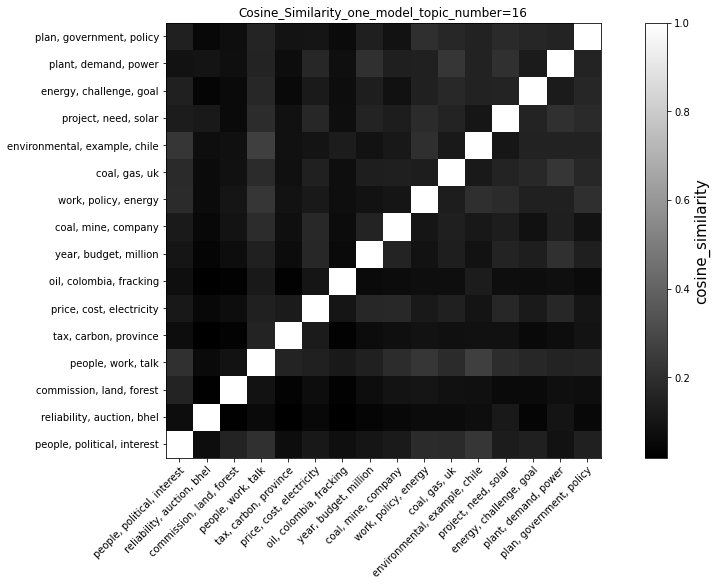

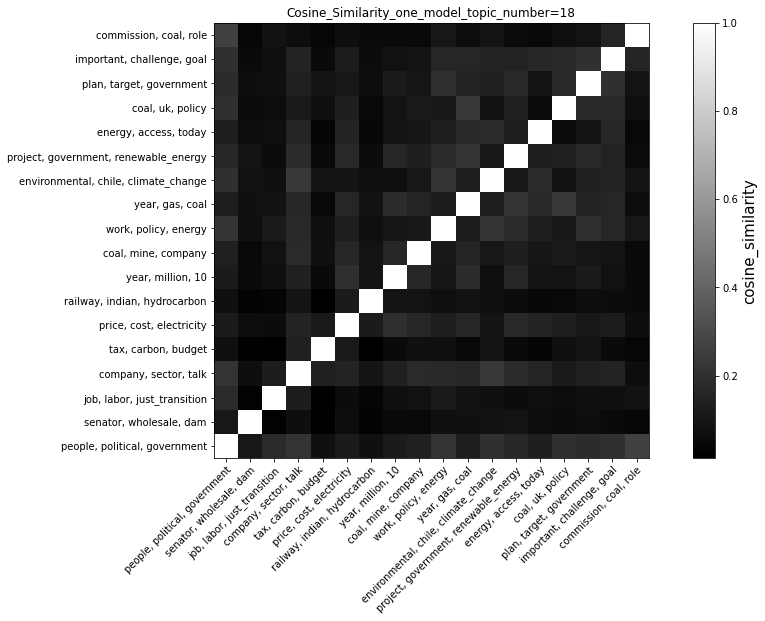

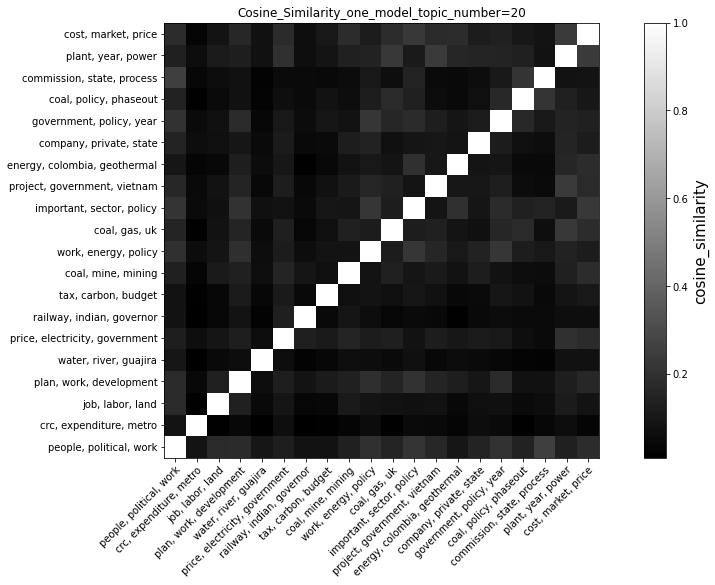

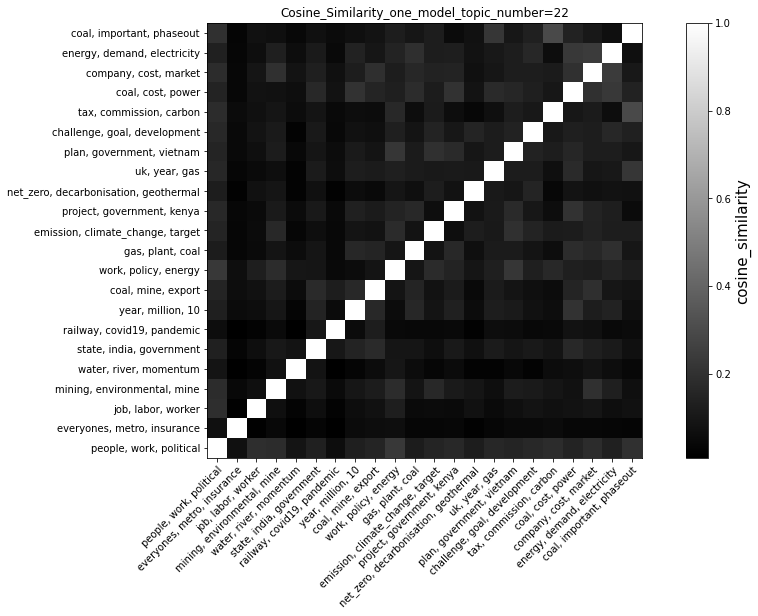

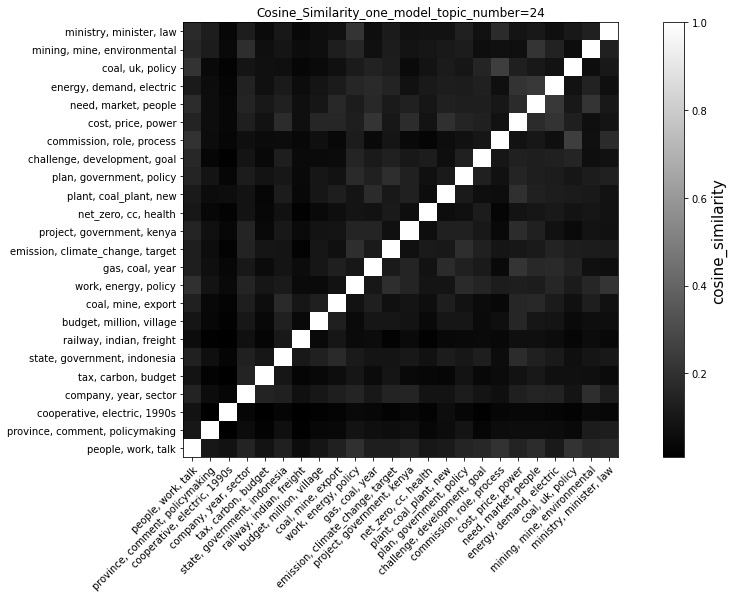

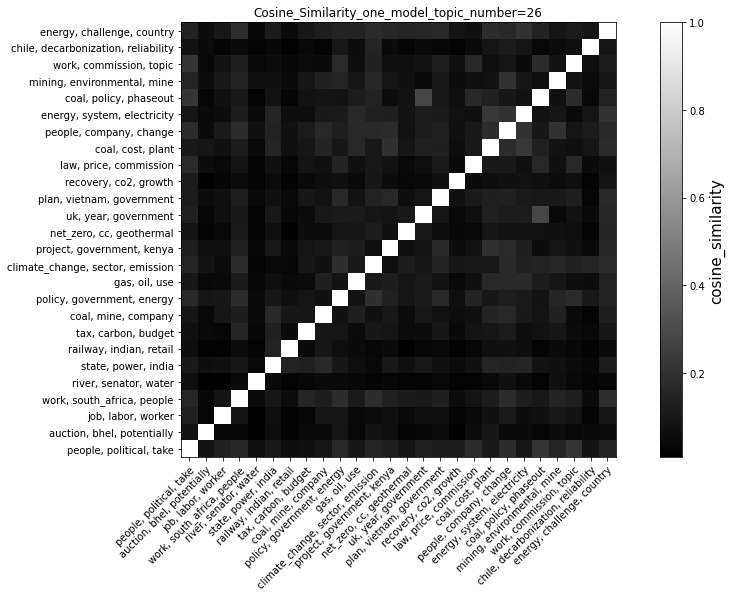

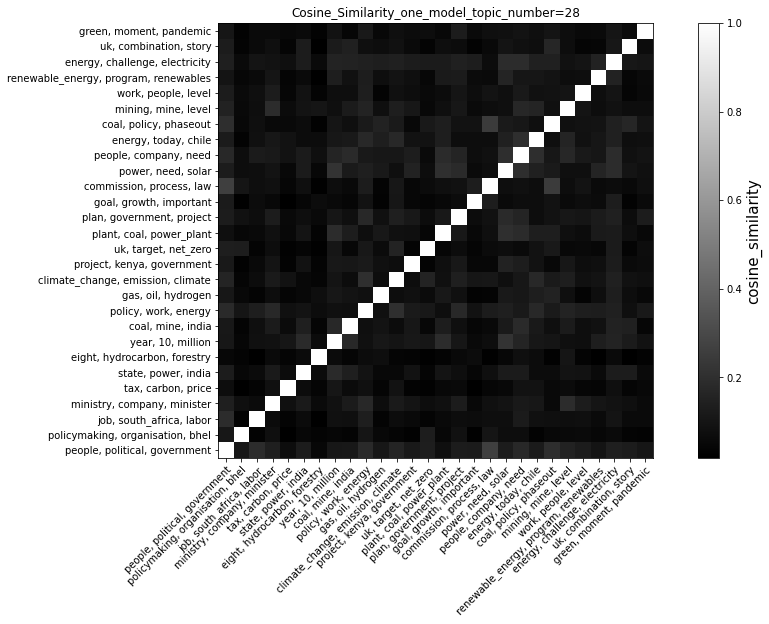

In [30]:
#compare one model, plot
for x in no_topics:
    cos_sim = cosine_similarity(dict_dfs_topics_per_doc_x['tnum_'+str(x)].values.T)
    xaxis = dict_lists_columns_x['tnum_'+str(x)]
    yaxis = dict_lists_columns_x['tnum_'+str(x)]
    title = 'Cosine_Similarity_one_model_topic_number='+str(x)
    plot_cosine_difference_plt(cos_sim, xaxis, yaxis, title)
    for y in ['png', 'svg']: 
        plt.savefig('.\\results\LDA_set_parameters\parameters_lda\graphs_topicnum\qa_10_graph_'+title+'_'+timestr+'_V01.'+y, \
            bbox_inches="tight")

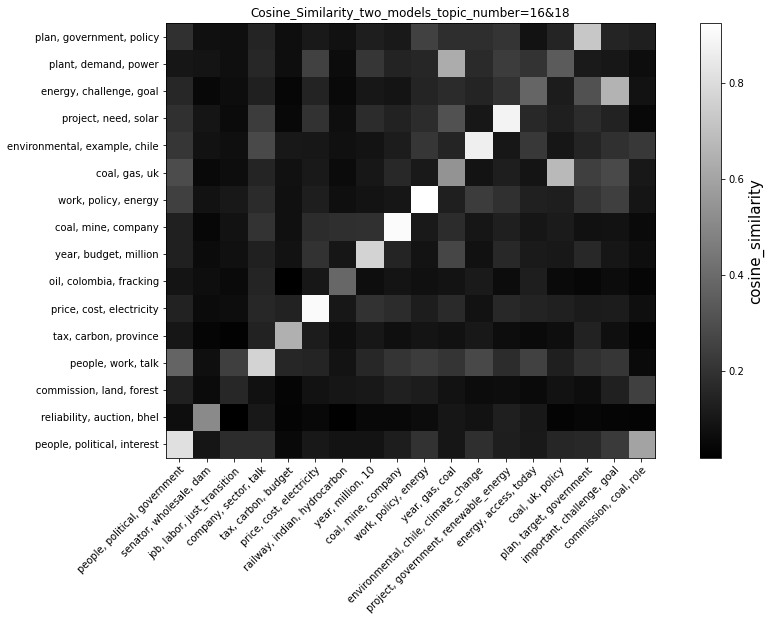

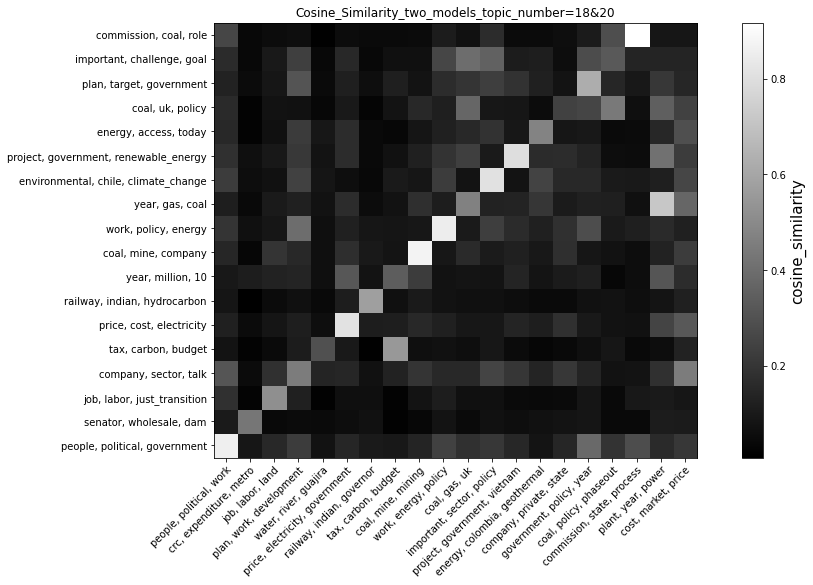

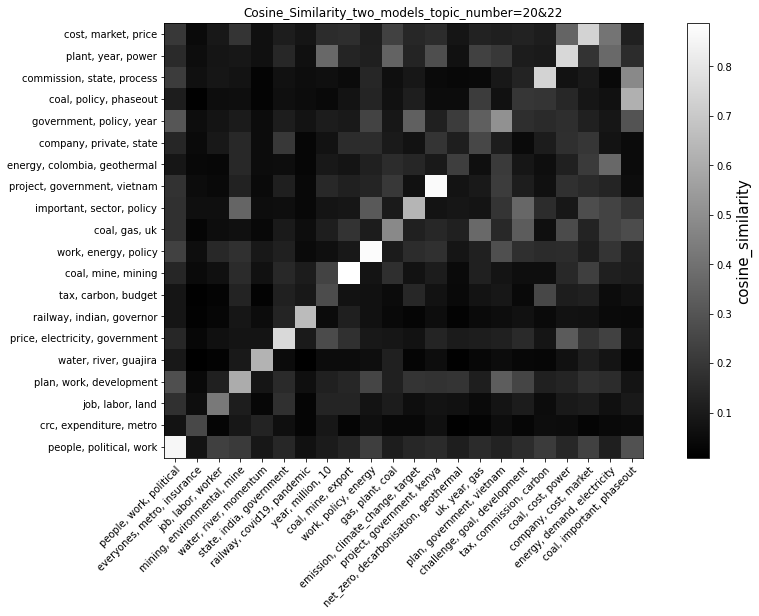

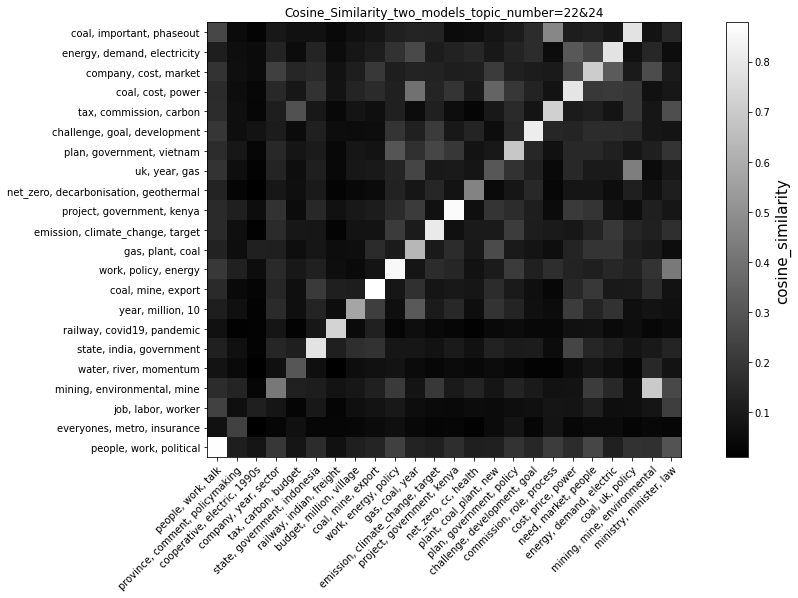

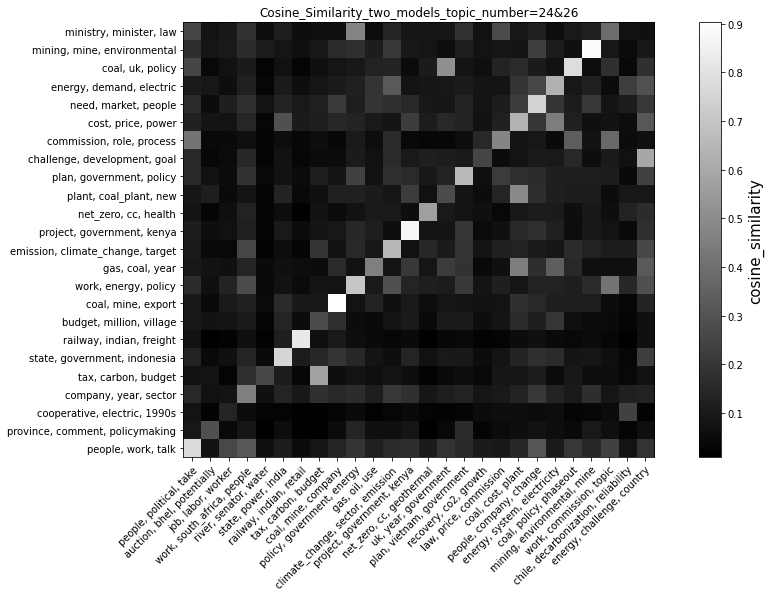

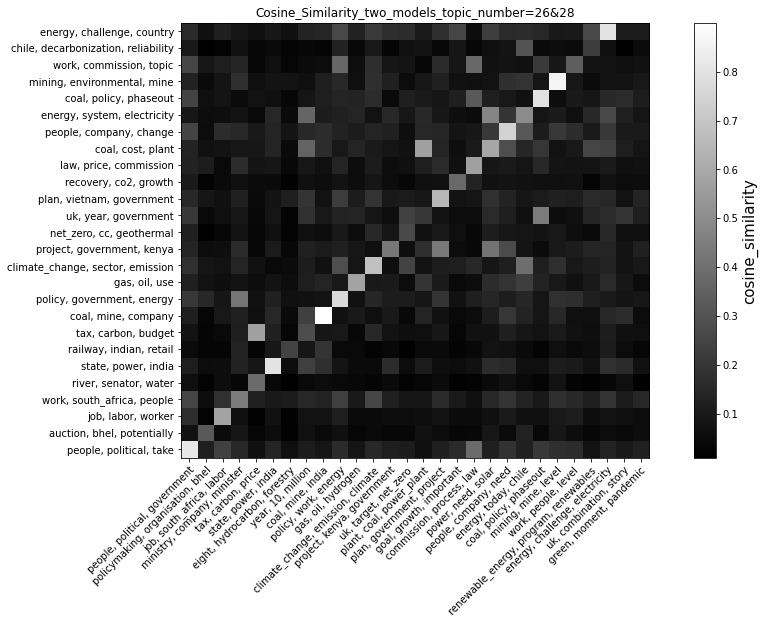

In [31]:
#compare two models, plot
for n in range(0, len(no_topics)):
    if n != len(no_topics)-1:
        x = no_topics[n]
        x2 = no_topics[n+1]
        cos_sim = cosine_similarity(dict_dfs_topics_per_doc_x['tnum_'+str(x)].values.T, \
                                    dict_dfs_topics_per_doc_x['tnum_'+str(x2)].values.T)
        xaxis = dict_lists_columns_x['tnum_'+str(x2)]
        yaxis = dict_lists_columns_x['tnum_'+str(x)]
        title = 'Cosine_Similarity_two_models_topic_number='+str(x)+'&'+str(x2)
        plot_cosine_difference_plt(cos_sim, xaxis, yaxis, title)
        for y in ['png', 'svg']: 
            plt.savefig('.\\results\LDA_set_parameters\parameters_lda\graphs_topicnum\qa_10_graph_'+title+'_'+timestr+'_V01.'+y, \
                    bbox_inches="tight")

####  dataframe with jaccard similarity

Jaccard Similarity is a similarity metric that is used to determine how similar two data points are with each other. It is, originally, defined over sets as (Intersection between two sets) / (Union of two sets). <br>
Jaccard Similarity is 0 if the sets are distinct, and 1 if the sets are same

In [48]:
#heatmap to compare similarity of topics
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""

    annotation_html = None
    if annotation is not None:
        annotation_html = [["+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row] for row in annotation]

    data = go.Heatmap(z=mdiff, colorscale=[[0, 'white'], [1, 'black']], text=annotation_html)
    layout = go.Layout(width=800, height=800, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    fig = dict(data=[data], layout=layout)
    return(fig)

In [49]:
#compare topic similarity within each model:
list_keys = list(dict_models_10_topicnum.keys())
dict_mdiffs = {}
for n in range(0, len(list_keys)):
    tn_1 = list_keys[n]
    if n+1 in range(0, len(list_keys)):
        tn_2 = list_keys[n+1]
        tn1_ldamodel = dict_models_10_topicnum[tn_1]
        tn2_ldamodel = dict_models_10_topicnum[tn_2]
        array_mdiff, annotation = tn1_ldamodel.diff(tn2_ldamodel, distance='jaccard', num_words=50)
        dict_mdiffs[tn_1+'_&_'+tn_2] = pd.DataFrame(array_mdiff)
        fig = plot_difference_plotly(array_mdiff, title="Two_models_topic_difference_"+tn_1+'_&_'+tn_2, annotation=annotation)
        offline.iplot(fig, filename='qa_10_Two_models_jaccard_topicnum_'+tn_1+'_&_'+tn_2+'_'+timestr+'_V01', image='png')

In [50]:
#use matrix to determine similar topics in graph using jaccard similarity
#For the model with more topics, check for each topic, which score is lowest (highest similarity)
dict_topics_match = {}
for y in dict_mdiffs.keys():
    df_mdiffs = dict_mdiffs[y]
    dict_similar_tn2_to_tn1 = {}
    for x in df_mdiffs.columns:
        var_min = df_mdiffs[x].min() #search for the lowest value in each column (topic in model 2)
        z = df_mdiffs[df_mdiffs[x]==var_min].index[0] #check, which topic it is in model 1
        dict_similar_tn2_to_tn1[x] = z
    dict_topics_match[y] = dict_similar_tn2_to_tn1

In [51]:
#make df with keywords and topic score (contribution) for each topic and links between topics
df_keywords_contr_10_topicnum = pd.DataFrame\
        ({'tn_'+list(dict_models_10_topicnum.keys())[0]:range(0,no_topics[0])})#, index=range(0, 15)) #new df with the topic numbers of first model

n = 0 #to print progress and to get number of topics
var_runs = len(dict_models_10_topicnum) 

for x in dict_models_10_topicnum:
    x_ldamodel = dict_models_10_topicnum[x] 
    var_number_of_topics = no_topics[n]
    
    #add the corresponding topic numbers for the model before
    if n>0: #not for the first model
        dict_t_matches = dict_topics_match[var_x_before+'_&_'+x] #get the dict with the matched topics
        df_add = pd.DataFrame({x+'_to_'+var_x_before:list(dict_t_matches.values())})
        df_keywords_contr_10_topicnum = pd.concat([df_keywords_contr_10_topicnum, df_add], axis=1) 
    
    #add keywords
    list_topics_keywords = list()
    for y in range(0, var_number_of_topics):
        wp = x_ldamodel.show_topic(y, topn=10) #default: topn=10, number of words
        topic_keywords = ", ".join([word for word, prop in wp])
        list_topics_keywords.append(topic_keywords)
    df_keywords_contr_10_topicnum[x+'_keywords'] = pd.Series(list_topics_keywords)
    
    #add topic score
    #create dataframe with empty columns
    topics_per_doc_df = pd.DataFrame()
    list_topics_columns = list() #to use later
    for k in range(0,var_number_of_topics):
        topics_per_doc_df["perc_cont_"+str(k)] = []
    # Get relevant topics for each document, this takes a while
    for i, row in enumerate(x_ldamodel[doc_term_matrix_10]): #this provides a list with all topics and their percentage contribution
        # Get all the topics, Perc Contribution and Keywords for each document
        for j in row:
            topic_num = j[0]
            prop_topic = j[1]
            wp = x_ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            topics_per_doc_df.loc[i, "perc_cont_"+str(topic_num)] = prop_topic
    #get the total topic scores for each topic
    list_topic_scores = []
    for z in range(0,var_number_of_topics):
        #calculate the shares
        list_topic_scores.append(round((topics_per_doc_df['perc_cont_'+str(z)].sum()/len(doc_clean_10)*100),3))
    #add topic scores to dataframe
    df_keywords_contr_10_topicnum[str(x)+'_topic_scores'] = pd.Series(list_topic_scores)
    
    var_x_before = x
    
    #print progress
    n+=1
    p = str(n)+' / ' + str(var_runs)+' done'
    print(p, end="\r") #\r is Carriage return, starts at the beginning of the line

In [52]:
#sort dataframe, so the topics of each model are sorted by the similarity to the model before
df_all = df_keywords_contr_10_topicnum.copy()
df_topicnum_sorted = pd.DataFrame()

n = 0
for x in dict_models_10_topicnum:
    if n == 0:
        df_topicnum_sorted = df_all[['tn_'+x, x+'_keywords', x+'_topic_scores']].dropna()
    else: 
        df_x = df_all[[x+'_to_'+var_x_before, x+'_keywords', x+'_topic_scores']] 
        df_x = df_x.dropna() #because it's shorter (less topics)
        var_len_column= df_x[x+'_keywords'].notnull().sum()
        df_x['tn_'+x] = pd.Series(range(0, var_len_column))
        df_x = df_x.rename(columns={x+'_to_'+var_x_before:'tn_'+var_x_before})
        #df_x = df_x.sort_values(x+'_to_'+var_x_before).reset_index(drop=True)
        df_topicnum_sorted = df_topicnum_sorted.merge(df_x, how='outer')
    var_x_before = x
    n+=1
#sort values by first model
df_topicnum_sorted = \
        df_topicnum_sorted.sort_values('tn_'+list(dict_models_10_topicnum.keys())[0]).reset_index(drop=True)

In [53]:
#try to group dataframe with multiindex
df_topicnum_sorted_10_kw = df_topicnum_sorted.copy()
a = list(df_topicnum_sorted_10_kw.columns)
df_topicnum_sorted_10_kw['total_links'] = range(0, len(df_topicnum_sorted_10_kw))
df_topicnum_grouped_10_kw = df_topicnum_sorted_10_kw.groupby(a,dropna=False)[['total_links']].sum()

In [54]:
df_topicnum_grouped_10_kw.to_excel\
        ('.\\results\LDA_set_parameters\parameters_lda\qa_overview_10_topicnum_match_10_keyw_'+timestr+'_V01.xlsx')

In [55]:
#do only with 3 keywords:
df_topicnum_sorted_3_kw = df_topicnum_sorted.copy()
for x in df_topicnum_sorted_3_kw.columns:
    if 'keywords' in x:
        for y in df_topicnum_sorted_3_kw.index:
            if type(df_topicnum_sorted_3_kw.loc[y, x]) == str:
                var_list = df_topicnum_sorted_3_kw.loc[y, x].split(' ')[0:3]
                var_str = ' '.join([i for i in var_list])
                df_topicnum_sorted_3_kw.loc[y, x] = var_str

In [56]:
#group dataframe with multi-index
a = list(df_topicnum_sorted_3_kw.columns)
df_topicnum_sorted_3_kw['total_links'] = range(0, len(df_topicnum_sorted_3_kw))
df_topicnum_grouped_3_kw = df_topicnum_sorted_3_kw.groupby(a,dropna=False)[['total_links']].sum()

In [57]:
#export as excel file and csv
df_topicnum_grouped_3_kw.to_excel\
        ('.\\results\LDA_set_parameters\parameters_lda\qa_overview_10_topicnum_match_03_keyw_'+timestr+'_V01.xlsx')

df_topicnum_grouped_3_kw.to_csv\
        ('.\\results\LDA_set_parameters\parameters_lda\qa_overview_10_topicnum_match_03_keyw_'+timestr+'_V01.csv',
            sep=';', decimal=',')

In [138]:
topic_num_final = 22

lda_final = dict_models_LONGdocs_topicnum['tnum_'+str(topic_num_final)]
df_kewywords_score = (df_keywords_contr_LONGdocs_topicnum[['tnum_'+str(topic_num_final)+'_topic_scores', \
                            'tnum_'+str(topic_num_final)+'_keywords']]).dropna(how='any')

## final checks

In [139]:
#get dataframe with the topic scores for each topic for each document
#this takes a while!
def get_df_topics_per_doc(sent_lda, sent_doc_term_matrix):
    df_x = pd.DataFrame()
    # Get relevant topics for each document, this takes a while
    for i, row in enumerate(sent_lda[sent_doc_term_matrix]): #this provides a list with all topics and their percentage contribution
        # Get all the topics, Perc Contribution and Keywords for each document
        for j in row:
            topic_num = j[0]
            prop_topic = j[1]
            wp = sent_lda.show_topic(topic_num, topn=3)
            topic_num_keywords = ", ".join([word for word, prop in wp])
            df_x.loc[i, topic_num_keywords] = prop_topic
    return(df_x)

In [140]:
df_topics_per_doc_final = get_df_topics_per_doc(lda_final, doc_term_matrix_x)

### alpha

In [ ]:
#Q: do I get different topics for tn=22 when I use a different alpha?

In [141]:
var_alpha_a = 0.05 #try with alternative alpha
#choose the range for the topic-numbers 
topic_num_final = topic_num_final #defined above
var_passes = var_passes #defined on top of the notebook

In [142]:
ldamodel_a = get_ldamodel(var_alpha_a, topic_num_final, var_passes, doc_term_matrix_x, dictionary_x) #run the model

In [143]:
df_topics_per_doc_a = get_df_topics_per_doc(ldamodel_a, doc_term_matrix_x)

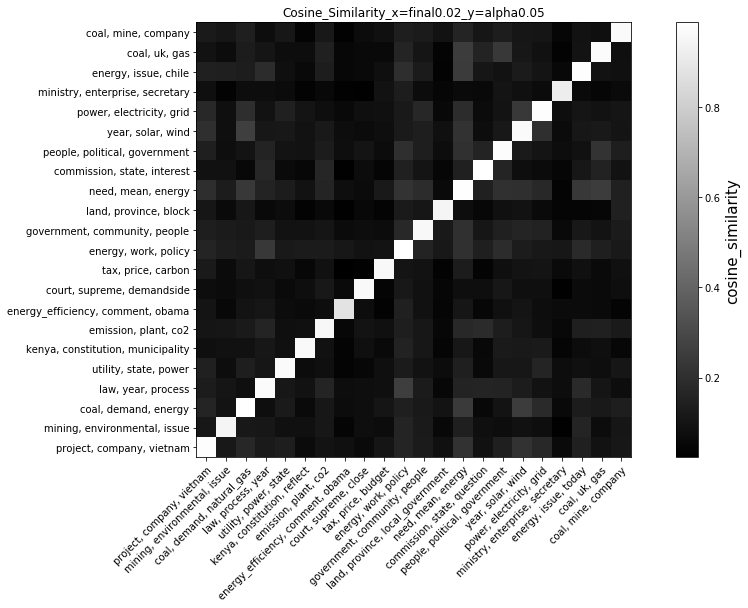

In [144]:
#make graph
#compare two models, plot

cos_sim = cosine_similarity(df_topics_per_doc_a.values.T, df_topics_per_doc_final.values.T)
xaxis = df_topics_per_doc_final.columns
yaxis = df_topics_per_doc_a.columns
title = 'Cosine_Similarity_x=final'+str(var_alpha_2)+'_y=alpha'+str(var_alpha_a)
plot_cosine_difference_plt(cos_sim, xaxis, yaxis, title)

plt.savefig('.\\results\LDA_set_parameters\parameters_lda\graphs_topicnum\graph_'+title+'_'+timestr+'_V01.png', \
                   bbox_inches="tight")